# GCNNによる各点の座標の予測

## Colabで実行するときの設定

In [24]:
# GoogleDriveのマウント

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/source/dna-microscopy/2D/diffusion_deep_learning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/source/dna-microscopy/2D/diffusion_deep_learning


In [25]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [26]:
# DGLのインストール(上の出力でcudaのバージョンを確認する)
!pip install dgl-cu101
#!pip install dgl

!pip list | grep torch
!pip list | grep dgl

torch                    1.5.1+cu101    
torchsummary             1.5.1          
torchtext                0.3.1          
torchvision              0.6.1+cu101    
dgl-cu101                0.4.3.post2    


## 実験条件

- ネットワーク: GCNN
- 拡散時間t=20, ビーズの数nBeads=100
- 作った隣接行列：1~9の各クラスで5000ずつ(訓練：5000x9-9000=36000 ，検証：500x9=4500，テスト：500x9=4500)
- バッチサイズ：128

## パッケージのインポート

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from scipy.io import mmread
from sklearn.model_selection import train_test_split
import random
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph
from dgl.nn.pytorch import GraphConv

In [28]:
plt.ion()   # interactive mode

torch.set_default_tensor_type(torch.FloatTensor)

# random seed
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## データの用意

### データの読み込み

In [57]:
test_run = False

#データの読み込み
#amt.shape==(nSample * 9, nBeads**2 + 1), 最後の1列は各レコードのターゲットになっている
if test_run:
    # プログラムが動くかどうかのテスト用の小さいデータ．shape=（5*9, 32*32 + 1）
    adjMats = mmread("small_adjMats.mtx").toarray().astype(np.float32)
    coords = mmread("small_coords.mtx").astype(np.float32)
    targets = mmread("small_targets.mtx")
    epoch_num = 5
    batch_size = 3
else:
    # 本番用データ
    adjMats = mmread("adjMats.mtx").toarray().astype(np.float32)
    coords = mmread("coords.mtx").astype(np.float32)
    targets = mmread("targets.mtx")
    epoch_num = 100
    batch_size = 128

nBeads = int(np.sqrt(adjMats.shape[1]))
nDim = 2

# vggを使うためデータのshapeを(nSmaple*9, 1, nBeads,nBeads)にする.第2次元はチャネル数に相当する．
adjMats = adjMats.reshape(adjMats.shape[0], 1, nBeads, nBeads)
coords = coords.reshape(adjMats.shape[0], nBeads, nDim)

### dataset, dataloaderの作成

In [58]:
def my_collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(torch.cat(labels, dim=0))
    #return batched_graph, torch.stack(labels)

use_collate = True
if use_collate:
    collate = my_collate
else:
    collate = None

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        #return self.x_train.shape[0]
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], torch.tensor(self.t_train[idx], dtype=torch.float)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test

    def __len__(self):
        #return self.x_test.shape[0]
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.x_test[idx]

data_list = []

for i, a in enumerate(adjMats):
    # 読み込んだデータの整形
    a = a.squeeze()
    e_index = np.where(a > 0)
    src = e_index[0]
    dst = e_index[1]

    # DGLのデータを作成
    #g = dgl.DGLGraph(e_index)
    g = dgl.DGLGraph()
    g.add_nodes(nBeads)
    #g.add_edges(list(e_index))
    g.add_edges(src, dst)

    g.ndata["x"] = np.ones((nBeads, 1)).reshape(-1,1).astype(np.float32)
    #g.ndata["cood"] = coords
    g.edata["weight"] = a[e_index].reshape(-1,1)

    #data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))
    data_list.append(g)


test_size = int(len(data_list) * 0.1)

x_trainval_data, x_test_data, t_trainval_data, t_test_data = train_test_split(data_list, coords, test_size=test_size, shuffle=True)
#train_data, val_data = train_test_split(trainval_data, test_size=test_size, random_state=0)

trainval_set = train_dataset(x_trainval_data, t_trainval_data)
val_size = test_size
train_size = len(trainval_set) - val_size
train_set, val_set = torch.utils.data.random_split(trainval_set,[train_size, val_size])

test_set = test_dataset(x_test_data)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate
)

## モデルの定義

### ネットワークの定義

In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(GCN, self).__init__()
        #self.conv1 = GraphConv(in_feats, hidden_size)
        #self.conv2 = GraphConv(hidden_size, out_feats)

        self.conv1 = GraphConv(in_feats, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 48)
        self.conv4 = GraphConv(48, 64)
        self.conv5 = GraphConv(64, 96)
        self.conv6 = GraphConv(96, 128)
        self.linear1 = torch.nn.Linear(128,64)
        #TODO: 分類数への依存をなくす
        self.linear2 = torch.nn.Linear(64, out_feats)

    def forward(self, g, inputs):
        #h = self.conv1(g, inputs)
        #h = torch.relu(h)
        #h = self.conv2(g, h)

        x = self.conv1(g, inputs)
        x = F.relu(x)
        x = self.conv2(g, x)
        x = F.relu(x)
        x = self.conv3(g, x)
        x = F.relu(x)
        x = self.conv4(g, x)
        x = F.relu(x)
        x = self.conv5(g, x)
        x = F.relu(x)
        x = self.conv6(g, x)
        x = F.relu(x)
        
        #x = scatter(x, data.batch, dim=0, reduce="max")
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)

        #return h
        return x

### 学習

In [59]:
start = time.time()

train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)

model = GCN(1,5,2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(epoch_num):
    train_loss = 0.0
    
    model.train()
    for i, data in enumerate(train_loader):
        
        b_graph, b_coords = data
        b_graph.to(device)
        b_coords.to(device)

        optimizer.zero_grad()
        prediction = model(b_graph, b_graph.ndata["x"])
        #prediction = model(b_graph, b_input)
        loss = criterion(prediction, b_coords)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item()
        if i % 10 == 9:
            progress_bar = '['+('='*((i+1)//10))+(' '*((train_size//100-(i+1))//10))+']'
            print('\repoch: {:d} loss: {:.3f}  {}'
                .format(
                    epoch + 1,
                    loss.cpu().item(),
                    progress_bar),
                end="  ")
            

    print('\repoch: {:d} loss: {:.3f}'
        .format(epoch + 1, train_loss / (train_size / batch_size)), end="  ")
    history["train_loss"].append(train_loss / (train_size / batch_size))


    batch_num = 0
    loss = 0
    model.eval()
    with torch.no_grad():
        for b_graph, b_coords in val_loader:
            b_graph.to(device)
            b_coords.to(device)
            prediction = model(b_graph, b_graph.ndata["x"])
            loss += criterion(prediction, b_coords)

            batch_num += 1

    history["val_loss"].append(loss.cpu().item()/batch_num)
    endstr = ' '*max(1,(train_size//1000-39))+"\n"
    print(f'Val Loss: {loss.cpu().item()/batch_num:.3f}',end=endstr)


print('Finished Training')
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch: 1 loss: 0.650  [===  ]  

KeyboardInterrupt: ignored

In [49]:
g = test_set[0]
type(g)
print(targets.shape)
print(len(adjMats))

(900, 1)
900


## 可視化

(50, 2)
torch.Size([50, 2])


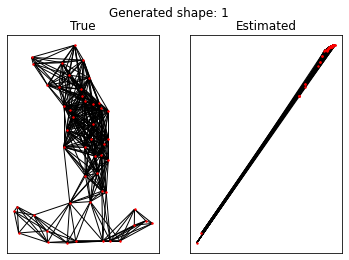

In [56]:
t_index = 0

node_list = list(range(nBeads))

# テストデータのノードの座標を予想
t_graph = test_set[t_index]
model.eval()
with torch.no_grad():
    #b_graph.to(device)
    #b_coords.to(device)
    t_graph.to(device)
    #prediction = model(b_graph, b_graph.ndata["x"])
    e_coords = model(t_graph, t_graph.ndata["x"])
    #loss += criterion(prediction, b_coords)

# 描画のためのグラフを作成
t_src, t_dst = np.where(adjMats[t_index].squeeze() > 0)
t_coords = coords[t_index]

G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(list(zip(t_src, t_dst)))

fig = plt.figure()
fig.suptitle("Generated shape: {}".format(targets[t_index, 0]))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("True")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Estimated")

true_pos = dict(zip(node_list, t_coords))
nx.draw_networkx(G, pos=true_pos, with_labels=False, ax=ax1,
                 node_color="red", node_size=2)

estimated_pos = dict(zip(node_list, e_coords.cpu().detach().numpy()))
nx.draw_networkx(G, pos=estimated_pos, with_labels=False, ax=ax2,
                 node_color="red", node_size=2)

plt.show()